# Exploratory Data Analysis - Hyperspectral (HS) Images

<div style="background: linear-gradient(135deg, #1e3c72 0%, #2a5298 100%); padding: 20px; border-radius: 10px; color: white;">

## Table of Contents
1. **Configuration & Import Libraries**
2. **Dataset Overview**
3. **Metadata Analysis & Image Structure**
4. **Class Distribution Analysis**
5. **Image Quality & Black Image Detection**
6. **Pixel Value & Statistical Analysis**
7. **Spectral Signature Analysis**
8. **Band Correlation Analysis**
9. **Sample Image Visualization**
10. **Dimensionality Reduction Analysis**
11. **Anomaly Detection**
12. **Summary & Recommendations**

</div>

---

**Analysis Date:** February 2026  
**Objective:** Comprehensive analysis of Hyperspectral image data for plant disease classification

In [12]:
# ============================================================================
# SECTION 1: IMPORT LIBRARIES & CONFIGURATION
# ============================================================================

import os
import glob
import warnings
import pandas as pd
import numpy as np
import tifffile as tiff
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from tqdm import tqdm
from scipy import stats
from scipy.signal import savgol_filter
from collections import Counter
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════════════════
# PROFESSIONAL STYLE CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Custom color palette
COLORS = {
    'primary': '#1e3c72',      # Dark blue
    'secondary': '#2a5298',    # Medium blue
    'accent': '#f39c12',       # Orange
    'success': '#27ae60',      # Green
    'danger': '#e74c3c',       # Red
    'background': '#ecf0f1',   # Light gray
    'Health': '#27ae60',       # Green - Healthy
    'Rust': '#e74c3c',         # Red - Rust disease
    'Other': '#9b59b6',        # Purple - Other
    'Unknown': '#95a5a6'       # Gray - Unknown
}

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'figure.dpi': 100,
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True
})

# ═══════════════════════════════════════════════════════════════════════════
# DATASET PATH DEFINITION
# ═══════════════════════════════════════════════════════════════════════════

BASE_DIR = r'D:\GitHub\AI-for-Agriculture-2026\dataset'
HS_TRAIN_DIR = os.path.join(BASE_DIR, 'train', 'HS')
HS_VAL_DIR = os.path.join(BASE_DIR, 'val', 'HS')

# Hyperspectral wavelength range (typically 400-1000nm with ~150 bands)
# Will be determined from actual data
HS_WAVELENGTH_RANGE = (400, 1000)  # nm

print("Libraries imported successfully!")
print(f"Train Directory: {HS_TRAIN_DIR}")
print(f"Validation Directory: {HS_VAL_DIR}")
print(f"Expected HS Wavelength Range: {HS_WAVELENGTH_RANGE[0]}-{HS_WAVELENGTH_RANGE[1]}nm")

Libraries imported successfully!
Train Directory: D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS
Validation Directory: D:\GitHub\AI-for-Agriculture-2026\dataset\val\HS
Expected HS Wavelength Range: 400-1000nm


---
## Section 2: Dataset Overview & Metadata Collection

> Scan the entire dataset to collect information about structure, size, and image metadata.

In [13]:
# ============================================================================
# SECTION 2: COMPREHENSIVE METADATA COLLECTION
# ============================================================================

def collect_hs_metadata(img_dir, split_name="train"):
  
    paths = glob.glob(os.path.join(img_dir, "**/*.tif*"), recursive=True)
    rows = []
    
    print(f"Scanning {len(paths)} HS images in {split_name} set...")
    
    for p in tqdm(paths, desc=f"Processing {split_name}", ncols=80):
        filename = os.path.basename(p)
        
        # Extract class from filename
        if filename.startswith('Health'):
            label = 'Health'
        elif filename.startswith('Rust'):
            label = 'Rust'
        elif filename.startswith('Other'):
            label = 'Other'
        else:
            label = 'Unknown'
        
        try:
            with tiff.TiffFile(p) as tf:
                series = tf.series[0]
                shape = series.shape
                dtype = series.dtype
                
                # Determine layout and dimensions
                if len(shape) == 3:
                    if shape[0] < shape[2]:
                        c, h, w = shape
                        layout = "CHW"
                    else:
                        h, w, c = shape
                        layout = "HWC"
                else:
                    h, w = shape[:2]
                    c = 1
                    layout = "2D"
                
                # File size
                file_size_mb = os.path.getsize(p) / (1024 * 1024)
                
                rows.append({
                    "File Name": filename,
                    "Path": p,
                    "Split": split_name,
                    "Class": label,
                    "Height": h,
                    "Width": w,
                    "Channels": c,
                    "Dtype": str(dtype),
                    "Layout": layout,
                    "Resolution": f"{h}x{w}",
                    "Total Pixels": h * w,
                    "File Size (MB)": round(file_size_mb, 3),
                    "Aspect Ratio": round(w / h, 2) if h > 0 else 0
                })
                
        except Exception as e:
            rows.append({
                "File Name": filename,
                "Path": p,
                "Split": split_name,
                "Class": label,
                "Error": str(e)
            })
    
    return pd.DataFrame(rows)

# Collect metadata from train and val sets
df_train = collect_hs_metadata(HS_TRAIN_DIR, "train")

# Use only train set for EDA
df_hs = df_train.copy()

print(f"\nTotal images collected: {len(df_hs)}")
print(f"   Train: {len(df_train)} images")

Scanning 600 HS images in train set...


Processing train:   0%|                                 | 0/600 [00:00<?, ?it/s]

Processing train: 100%|██████████████████████| 600/600 [00:00<00:00, 810.82it/s]


Total images collected: 600
   Train: 600 images


---
## Section 3: Dataset Summary Statistics

> Display comprehensive dataset overview with professional statistical tables.

In [14]:
# ============================================================================
# SECTION 3: DATASET OVERVIEW & SUMMARY STATISTICS
# ============================================================================

def create_summary_table(df):
    """Create professional dataset summary table"""
    
    summary_data = {
        'Metric': [
            'Total Images',
            'Train Images', 
            'Number of Classes',
            'Image Height',
            'Image Width',
            'Number of Channels',
            'Total Dataset Size',
            'Average File Size'
        ],
        'Value': [
            f"{len(df):,}",
            f"{len(df[df['Split']=='train']):,}",
            f"{df['Class'].nunique()}",
            f"{df['Height'].mode().iloc[0] if not df.empty else 'N/A'}px",
            f"{df['Width'].mode().iloc[0] if not df.empty else 'N/A'}px",
            f"{df['Channels'].mode().iloc[0] if not df.empty else 'N/A'}",
            f"{df['File Size (MB)'].sum():.2f} MB",
            f"{df['File Size (MB)'].mean():.3f} MB"
        ]
    }
    
    return pd.DataFrame(summary_data)

# Display summary table
summary_df = create_summary_table(df_hs)
print("=" * 60)
print("HYPERSPECTRAL DATASET SUMMARY")
print("=" * 60)
display(summary_df.style.set_properties(**{
    'background-color': '#f8f9fa',
    'color': '#2c3e50',
    'border-color': '#dee2e6',
    'font-size': '12pt'
}).hide(axis='index'))

# Class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)

class_dist = df_hs.groupby(['Class', 'Split']).size().unstack(fill_value=0)
class_dist['Total'] = class_dist.sum(axis=1)
class_dist['Percentage'] = (class_dist['Total'] / class_dist['Total'].sum() * 100).round(2).astype(str) + '%'

display(class_dist.style.background_gradient(cmap='Blues', subset=['Total'])
        .set_properties(**{'font-size': '11pt'}))

# Basic statistics
print("\n" + "=" * 60)
print("BASIC STATISTICS")
print("=" * 60)
print(df_hs[['Height', 'Width', 'Channels', 'File Size (MB)']].describe())

HYPERSPECTRAL DATASET SUMMARY


Metric,Value
Total Images,600
Train Images,600
Number of Classes,3
Image Height,32px
Image Width,125px
Number of Channels,32
Total Dataset Size,147.22 MB
Average File Size,0.245 MB



CLASS DISTRIBUTION


Split,train,Total,Percentage
Class,,,
Health,200,200,33.33%
Other,200,200,33.33%
Rust,200,200,33.33%



BASIC STATISTICS
       Height       Width  Channels  File Size (MB)
count   600.0  600.000000     600.0      600.000000
mean     32.0  125.185000      32.0        0.245370
std       0.0    0.388622       0.0        0.000777
min      32.0  125.000000      32.0        0.245000
25%      32.0  125.000000      32.0        0.245000
50%      32.0  125.000000      32.0        0.245000
75%      32.0  125.000000      32.0        0.245000
max      32.0  126.000000      32.0        0.247000


---
## Section 4: Class Distribution Visualization

> Visualize class distribution with professional charts.

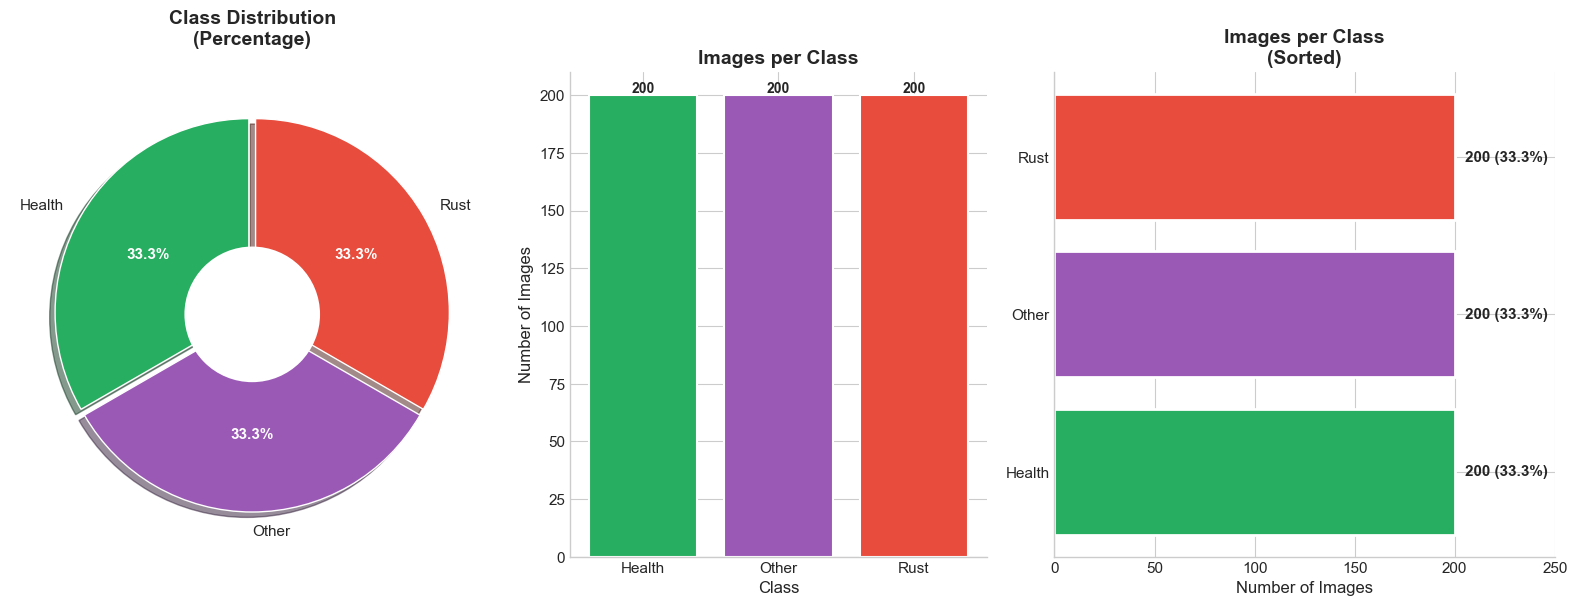

Figure saved: hs_class_distribution.png


In [15]:
# ============================================================================
# SECTION 4: CLASS DISTRIBUTION VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[1.2, 1, 1.2])

# --- Chart 1: Pie Chart with Donut Style ---
ax1 = fig.add_subplot(gs[0])
class_counts = df_hs['Class'].value_counts()
n_classes = len(class_counts)

class_colors_dynamic = [COLORS.get(cls, '#999999') for cls in class_counts.index]
explode_values = tuple([0.02] * n_classes)

wedges, texts, autotexts = ax1.pie(
    class_counts.values, 
    labels=class_counts.index,
    colors=class_colors_dynamic,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_values,
    shadow=True,
    wedgeprops=dict(width=0.7, edgecolor='white')
)
ax1.set_title('Class Distribution\n(Percentage)', fontsize=14, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

centre_circle = plt.Circle((0, 0), 0.35, fc='white')
ax1.add_patch(centre_circle)

# --- Chart 2: Bar Chart ---
ax2 = fig.add_subplot(gs[1])
bars = ax2.bar(class_counts.index, class_counts.values, 
               color=class_colors_dynamic, edgecolor='white', linewidth=1.5)
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Images')
ax2.set_title('Images per Class', fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# --- Chart 3: Horizontal Bar ---
ax3 = fig.add_subplot(gs[2])
sorted_counts = class_counts.sort_values()
sorted_colors = [COLORS.get(cls, '#999999') for cls in sorted_counts.index]
bars = ax3.barh(range(len(sorted_counts)), sorted_counts.values, 
                color=sorted_colors, edgecolor='white', linewidth=2)

ax3.set_yticks(range(len(sorted_counts)))
ax3.set_yticklabels(sorted_counts.index)
ax3.set_xlabel('Number of Images')
ax3.set_title('Images per Class\n(Sorted)', fontsize=14, fontweight='bold')

total = sorted_counts.sum()
for i, (bar, val) in enumerate(zip(bars, sorted_counts.values)):
    pct = val / total * 100
    ax3.text(val + 5, bar.get_y() + bar.get_height()/2, 
             f'{val:,} ({pct:.1f}%)', va='center', fontweight='bold', fontsize=11)

ax3.set_xlim(0, sorted_counts.max() * 1.25)

plt.tight_layout()
plt.savefig('hs_class_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: hs_class_distribution.png")

---
## Section 5: Image Dimensions & Quality Analysis

> Analyze image dimensions, check consistency, and detect anomalies.

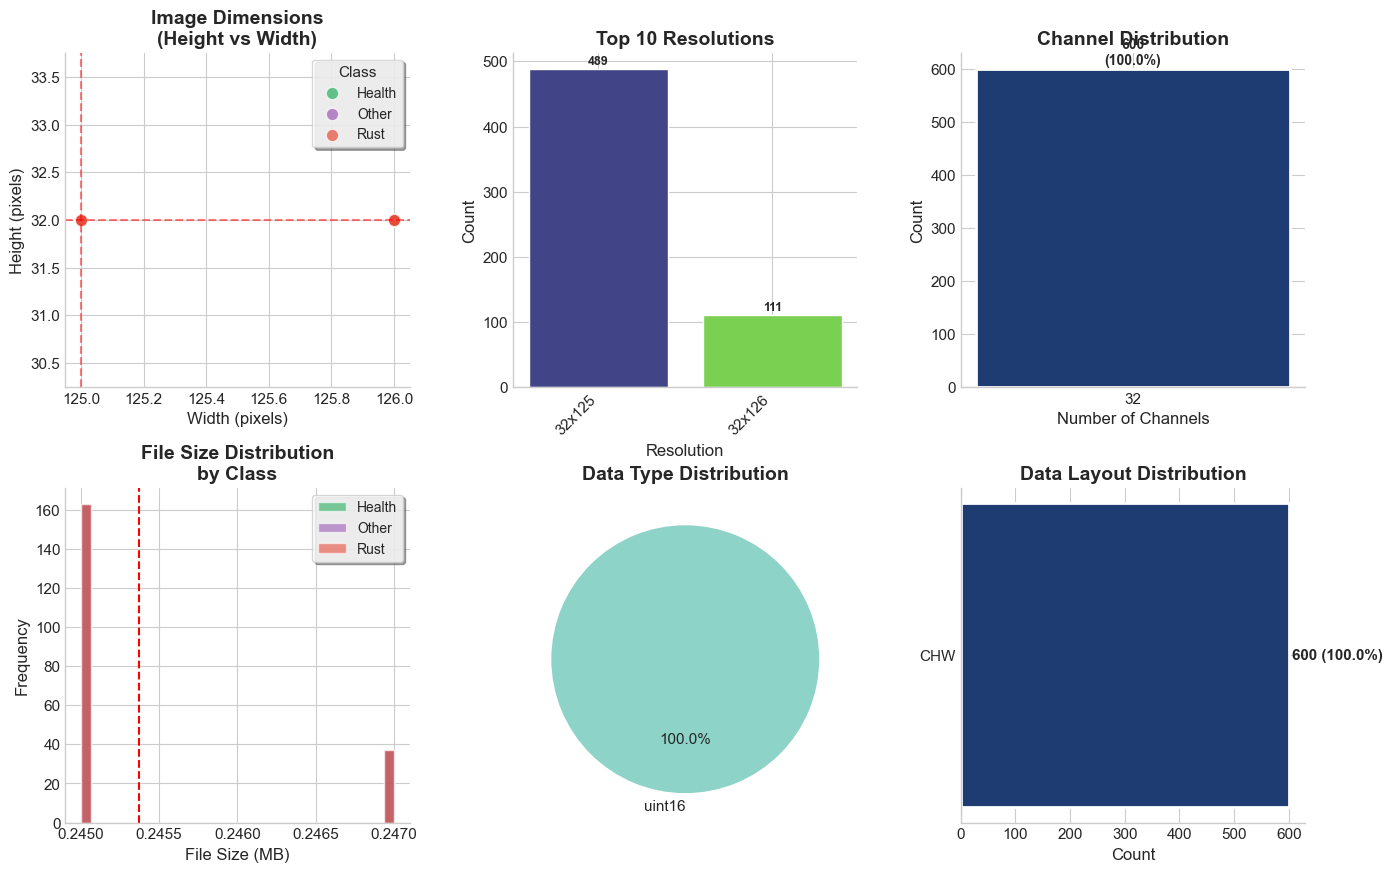

Figure saved: hs_dimensions_analysis.png


In [16]:
# ============================================================================
# SECTION 5: IMAGE DIMENSIONS & QUALITY ANALYSIS
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, hspace=0.3, wspace=0.3)

# --- Chart 1: Scatter Plot H vs W ---
ax1 = fig.add_subplot(gs[0, 0])
for cls in df_hs['Class'].unique():
    subset = df_hs[df_hs['Class'] == cls]
    ax1.scatter(subset['Width'], subset['Height'], 
                c=COLORS[cls], label=cls, alpha=0.7, s=80, edgecolors='white')

ax1.set_xlabel('Width (pixels)')
ax1.set_ylabel('Height (pixels)')
ax1.set_title('Image Dimensions\n(Height vs Width)', fontweight='bold')
ax1.legend(title='Class')
ax1.axhline(df_hs['Height'].median(), color='red', linestyle='--', alpha=0.5)
ax1.axvline(df_hs['Width'].median(), color='red', linestyle='--', alpha=0.5)

# --- Chart 2: Resolution Distribution ---
ax2 = fig.add_subplot(gs[0, 1])
resolution_counts = df_hs['Resolution'].value_counts().head(10)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(resolution_counts)))

bars = ax2.bar(range(len(resolution_counts)), resolution_counts.values, color=colors, edgecolor='white')
ax2.set_xticks(range(len(resolution_counts)))
ax2.set_xticklabels(resolution_counts.index, rotation=45, ha='right')
ax2.set_xlabel('Resolution')
ax2.set_ylabel('Count')
ax2.set_title('Top 10 Resolutions', fontweight='bold')

for bar, val in zip(bars, resolution_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)

# --- Chart 3: Channel Distribution ---
ax3 = fig.add_subplot(gs[0, 2])
channel_counts = df_hs['Channels'].value_counts().sort_index()
bars = ax3.bar(channel_counts.index.astype(str), channel_counts.values, 
               color=COLORS['primary'], edgecolor='white', linewidth=2)
ax3.set_xlabel('Number of Channels')
ax3.set_ylabel('Count')
ax3.set_title('Channel Distribution', fontweight='bold')

for bar, val in zip(bars, channel_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val}\n({val/len(df_hs)*100:.1f}%)', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

# --- Chart 4: File Size Distribution ---
ax4 = fig.add_subplot(gs[1, 0])
for cls in df_hs['Class'].unique():
    subset = df_hs[df_hs['Class'] == cls]
    ax4.hist(subset['File Size (MB)'], bins=30, alpha=0.6, 
             label=cls, color=COLORS[cls], edgecolor='white')

ax4.set_xlabel('File Size (MB)')
ax4.set_ylabel('Frequency')
ax4.set_title('File Size Distribution\nby Class', fontweight='bold')
ax4.legend()
ax4.axvline(df_hs['File Size (MB)'].mean(), color='red', linestyle='--', 
            label=f"Mean: {df_hs['File Size (MB)'].mean():.3f} MB")

# --- Chart 5: Data Type Distribution ---
ax5 = fig.add_subplot(gs[1, 1])
dtype_counts = df_hs['Dtype'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(dtype_counts)))

wedges, texts, autotexts = ax5.pie(
    dtype_counts.values, 
    labels=dtype_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=[0.03] * len(dtype_counts)
)
ax5.set_title('Data Type Distribution', fontweight='bold')

# --- Chart 6: Layout Distribution ---
ax6 = fig.add_subplot(gs[1, 2])
layout_counts = df_hs['Layout'].value_counts()

bars = ax6.barh(layout_counts.index, layout_counts.values, 
                color=[COLORS['primary'], COLORS['secondary'], COLORS['accent']][:len(layout_counts)],
                edgecolor='white', linewidth=2)
ax6.set_xlabel('Count')
ax6.set_title('Data Layout Distribution', fontweight='bold')

for bar, val in zip(bars, layout_counts.values):
    ax6.text(val + 5, bar.get_y() + bar.get_height()/2, 
             f'{val} ({val/len(df_hs)*100:.1f}%)', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('hs_dimensions_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: hs_dimensions_analysis.png")

---
## Section 5.1: Black Image Detection & Quality Check

> Check for black images or poor quality images similar to RGB and MS analysis.

---
## HƯỚNG DẪN: RE-RUN EDA VỚI DATASET ĐÃ LỌC

**Quy trình thực hiện:**

1. **Chạy Cell bên dưới (Section 5.1)** - Quality Check
   - Phát hiện 23 ảnh corrupt (mean=0, std=0, black_ratio=1.0)
   - Lưu report: `hs_quality_report.csv`
   - Hiển thị 6 ảnh mẫu bị lỗi

2. **Filtering tự động** - Loại bỏ ảnh lỗi
   - Dataset gốc: 600 ảnh
   - Dataset sau lọc: 577 ảnh (23 ảnh bị xóa)
   - Phân bố: Health (191/200), Other (186/200), Rust (200/200)

3. **Chạy tiếp các Cell từ Section 6 đến 10**
   - Section 6: Spectral Signature Analysis (clean images only)
   - Section 7: Band Correlation Analysis (clean images only)
   - Section 8: Sample Visualization (clean images only)
   - Section 9: Dimensionality Analysis (clean images only)
   - Section 10: Summary & Recommendations (clean images only)

**Lưu ý:**
- Tất cả các phân tích từ Section 6 trở đi đã **TỰ ĐỘNG sử dụng `df_hs` đã được filter**
- Không cần sửa code, chỉ cần chạy lại các cell theo thứ tự
- Các note "Clean Images Only" đã được thêm vào tiêu đề mỗi section

---

---
## Section 5.0: Inspect Sample HS Images First

> Check actual pixel value ranges of HS images before quality check.

Checking quality of HS images...
Total HS images to check: 600


Quality Check: 100%|█████████████████████████| 600/600 [00:01<00:00, 334.73it/s]



OVERALL QUALITY REPORT - HYPERSPECTRAL IMAGES
status
ok         577
flagged     23
Name: count, dtype: int64

DETAILED FLAGGED HS IMAGES REPORT (23 images)

FULL LIST OF FLAGGED HS IMAGES:
----------------------------------------------------------------------------------------------------


,filename,class,status,reason,mean_value,std_value,black_ratio,white_ratio,W,H,C,dtype
23,Health_hyper_12.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
60,Health_hyper_153.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
75,Health_hyper_167.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
116,Health_hyper_23.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,126,uint16
119,Health_hyper_26.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
128,Health_hyper_34.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,126,uint16
132,Health_hyper_38.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
164,Health_hyper_67.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
174,Health_hyper_76.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16
204,Other_hyper_102.tif,Other,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,32,32,125,uint16



FLAGGED IMAGES BY CLASS:
reason  near_black,low_contrast
class                          
Health                        9
Other                        14

Original file is locked. Quality report saved as: hs_quality_report_1770051164.csv

VISUALIZING SAMPLE FLAGGED HS IMAGES


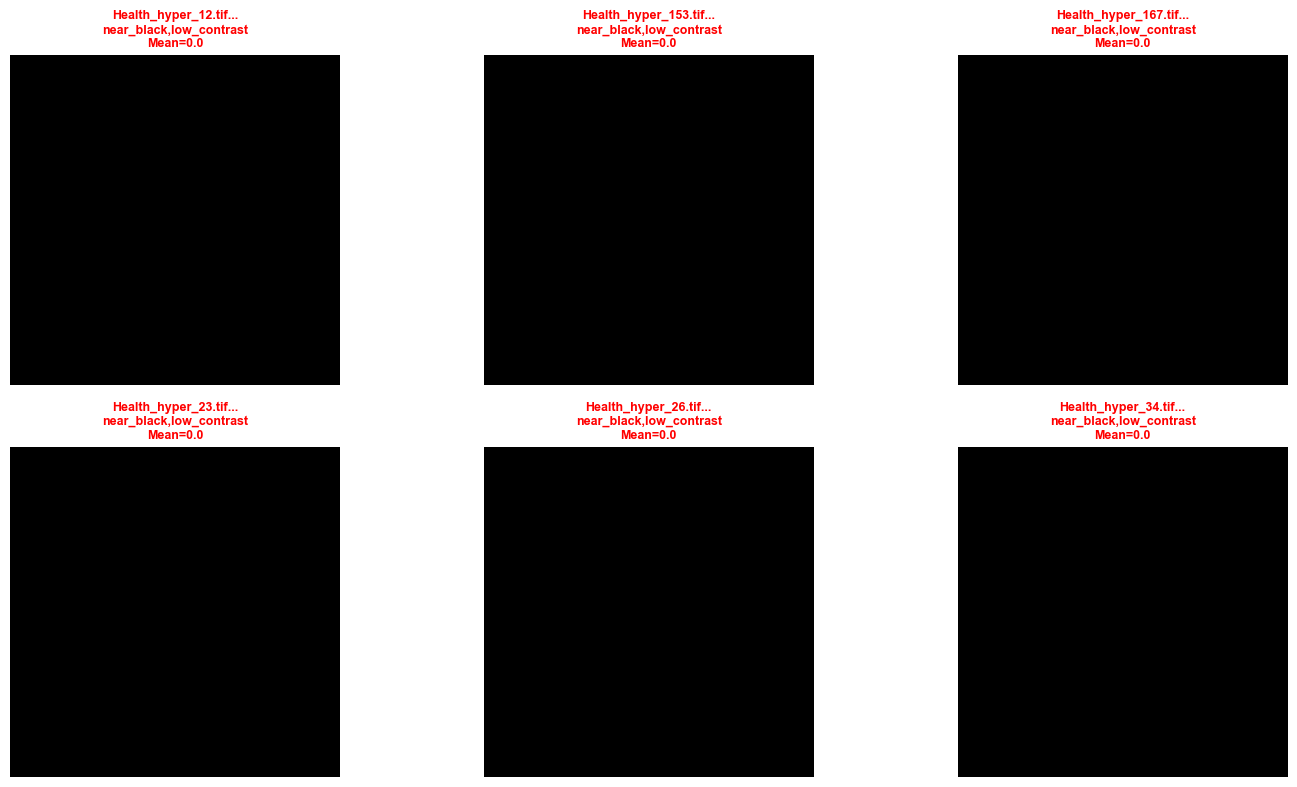

Figure saved: hs_flagged_samples.png

QUALITY CHECK COMPLETED

FILTERING DATASET - REMOVING FLAGGED IMAGES

Original dataset: 600 images
Filtered dataset: 577 images
Removed: 23 flagged images

CLASS DISTRIBUTION AFTER FILTERING
Class
Rust      200
Health    191
Other     186
Name: count, dtype: int64
Rust: 200/200 (0 removed, 100.0% retained)
Health: 191/200 (9 removed, 95.5% retained)
Other: 186/200 (14 removed, 93.0% retained)

PROCEEDING WITH ANALYSIS USING CLEAN IMAGES ONLY


In [17]:
# ============================================================================
# SECTION 5.1: BLACK IMAGE DETECTION & QUALITY CHECK
# ============================================================================

def quality_check_hs(path, 
                     black_mean_thr=50,
                     black_ratio_thr=0.98,
                     low_std_thr=30,
                     white_ratio_thr=0.98):
    """
    Check quality of HS (Hyperspectral) images.
    
    Parameters:
    -----------
    path : str - Path to HS image (.tif)
    black_mean_thr : float - Low mean threshold
    black_ratio_thr : float - Black pixel ratio threshold
    low_std_thr : float - Low std threshold (low contrast)
    white_ratio_thr : float - White pixel ratio threshold
    
    Returns:
    --------
    dict - Quality check information
    """
    
    row = {"path": path, "status": "ok", "reason": ""}
    
    # 1) Check corrupt
    try:
        with tiff.TiffFile(path) as tf:
            series = tf.series[0]
            shape = series.shape
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"verify_fail: {type(e).__name__}"
        return row
    
    # 2) Load and calculate stats
    try:
        img = tiff.imread(path)
        
        # Determine layout and convert to CHW
        # For hyperspectral: typically CHW with C~150, H,W~30-200
        if img.ndim == 3:
            # If first dimension is smallest => already CHW
            if img.shape[0] < min(img.shape[1], img.shape[2]):
                # Already CHW
                c, h, w = img.shape
            else:
                # HWC -> CHW
                h, w, c = img.shape
                img = np.transpose(img, (2, 0, 1))
        else:
            row["status"] = "corrupt"
            row["reason"] = "unexpected_shape"
            return row
        
        row["W"], row["H"], row["C"] = w, h, c
        
        # Downsample for faster computation (every 10th pixel)
        img_small = img[:, ::10, ::10].astype(np.float32)
        
        # Calculate mean across all bands
        mean_val = float(np.mean(img_small))
        std_val = float(np.std(img_small))
        
        # Adjust threshold based on data type
        if img.dtype == np.uint16:
            black_pixel_thr = 50
            white_pixel_thr = 60000
        else:
            black_pixel_thr = 10
            white_pixel_thr = 245
        
        black_ratio = float(np.mean(img_small <= black_pixel_thr))
        white_ratio = float(np.mean(img_small >= white_pixel_thr))
        
        row.update({
            "mean_value": mean_val,
            "std_value": std_val,
            "black_ratio": black_ratio,
            "white_ratio": white_ratio,
            "dtype": str(img.dtype)
        })
        
        # Flag detection
        flags = []
        if mean_val < black_mean_thr and black_ratio > black_ratio_thr:
            flags.append("near_black")
        if white_ratio > white_ratio_thr:
            flags.append("near_white")
        if std_val < low_std_thr:
            flags.append("low_contrast")
        
        if flags:
            row["status"] = "flagged"
            row["reason"] = ",".join(flags)
            
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"load_fail: {type(e).__name__}"
        return row
    
    return row

# Run quality check
print("Checking quality of HS images...")

hs_files = df_hs['Path'].tolist()
print(f"Total HS images to check: {len(hs_files)}")

quality_rows = []
for p in tqdm(hs_files, desc="Quality Check", ncols=80):
    result = quality_check_hs(p)
    quality_rows.append(result)

df_quality = pd.DataFrame(quality_rows)

# Summary statistics
print("\n" + "=" * 100)
print("OVERALL QUALITY REPORT - HYPERSPECTRAL IMAGES")
print("=" * 100)
print(df_quality["status"].value_counts())

# Flagged images
df_flagged = df_quality[df_quality["status"] != "ok"].copy()

if len(df_flagged) > 0:
    print("\n" + "=" * 100)
    print(f"DETAILED FLAGGED HS IMAGES REPORT ({len(df_flagged)} images)")
    print("=" * 100)
    
    df_flagged['filename'] = df_flagged['path'].apply(lambda x: os.path.basename(x))
    df_flagged['class'] = df_flagged['filename'].apply(lambda x: x.split('_')[0])
    df_flagged = df_flagged.sort_values(['class', 'reason', 'filename'])
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    print("\nFULL LIST OF FLAGGED HS IMAGES:")
    print("-" * 100)
    
    display_cols = ['filename', 'class', 'status', 'reason', 'mean_value', 'std_value', 
                   'black_ratio', 'white_ratio', 'W', 'H', 'C', 'dtype']
    display_cols = [col for col in display_cols if col in df_flagged.columns]
    
    styled_df = df_flagged[display_cols].style.set_properties(**{
        'background-color': '#fff3cd',
        'color': '#856404',
        'border-color': '#ffeaa7',
        'font-size': '10pt'
    }).background_gradient(subset=['mean_value', 'std_value', 'black_ratio'], cmap='RdYlGn')
    
    display(styled_df)
    
    print("\nFLAGGED IMAGES BY CLASS:")
    print(df_flagged.groupby(['class', 'reason']).size().unstack(fill_value=0))
    
    # Save report with error handling
    output_path = 'hs_quality_report.csv'
    try:
        df_flagged[display_cols].to_csv(output_path, index=False)
        print(f"\nQuality report saved: {output_path}")
    except PermissionError:
        import time
        output_path = f'hs_quality_report_{int(time.time())}.csv'
        df_flagged[display_cols].to_csv(output_path, index=False)
        print(f"\nOriginal file is locked. Quality report saved as: {output_path}")
    except Exception as e:
        print(f"\nWarning: Could not save CSV file. Error: {e}")
    
    # Visualize sample flagged images
    print("\n" + "=" * 100)
    print("VISUALIZING SAMPLE FLAGGED HS IMAGES")
    print("=" * 100)
    
    sample_flagged = df_flagged.head(6)
    
    n_samples = len(sample_flagged)
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, (_, row_data) in enumerate(sample_flagged.iterrows()):
        ax = axes[idx]
        
        try:
            img = tiff.imread(row_data['path'])
            
            # Convert to CHW with corrected logic
            if img.ndim == 3:
                if img.shape[0] < min(img.shape[1], img.shape[2]):
                    c, h, w = img.shape
                else:
                    h, w, c = img.shape
                    img = np.transpose(img, (2, 0, 1))
            
            # Create RGB-like composite from selected bands
            if img.shape[0] >= 3:
                # Use bands that might correspond to visible spectrum
                band_indices = [int(img.shape[0] * 0.2), int(img.shape[0] * 0.5), int(img.shape[0] * 0.8)]
                rgb = np.stack([img[band_indices[0]], img[band_indices[1]], img[band_indices[2]]], axis=-1)
            else:
                rgb = img[0]
            
            # Normalize for display
            rgb = rgb.astype(np.float32)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8) * 255
            rgb = rgb.astype(np.uint8)
            
            ax.imshow(rgb)
            ax.set_title(f"{row_data['filename'][:20]}...\n{row_data['reason']}\nMean={row_data.get('mean_value', 0):.1f}", 
                        fontsize=9, color='red', fontweight='bold')
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading:\n{str(e)[:50]}", 
                   ha='center', va='center', fontsize=10, color='red', 
                   transform=ax.transAxes)
            ax.axis('off')
    
    # Hide unused axes
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('hs_flagged_samples.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("Figure saved: hs_flagged_samples.png")
    
else:
    print("\nAll HS images passed quality check! No flagged images found.")

print("\n" + "=" * 100)
print("QUALITY CHECK COMPLETED")
print("=" * 100)

# ============================================================================
# FILTER OUT FLAGGED IMAGES - USE ONLY CLEAN DATA FOR SUBSEQUENT ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("FILTERING DATASET - REMOVING FLAGGED IMAGES")
print("=" * 100)

# Get paths of OK images only
ok_paths = set(df_quality[df_quality["status"] == "ok"]["path"].tolist())

# Filter df_hs to keep only OK images
df_hs_original = df_hs.copy()
df_hs = df_hs[df_hs['Path'].isin(ok_paths)].copy()

print(f"\nOriginal dataset: {len(df_hs_original)} images")
print(f"Filtered dataset: {len(df_hs)} images")
print(f"Removed: {len(df_hs_original) - len(df_hs)} flagged images")

# Show class distribution after filtering
print("\n" + "=" * 100)
print("CLASS DISTRIBUTION AFTER FILTERING")
print("=" * 100)
class_dist_clean = df_hs['Class'].value_counts()
print(class_dist_clean)

for cls in class_dist_clean.index:
    orig_count = len(df_hs_original[df_hs_original['Class'] == cls])
    clean_count = class_dist_clean[cls]
    removed = orig_count - clean_count
    print(f"{cls}: {clean_count}/{orig_count} ({removed} removed, {clean_count/orig_count*100:.1f}% retained)")

print("\n" + "=" * 100)
print("PROCEEDING WITH ANALYSIS USING CLEAN IMAGES ONLY")
print("=" * 100)

---
## Section 6: Spectral Signature Analysis (Clean Images Only)

> Analyze spectral signatures for each class - critical for hyperspectral analysis.
> **Note: Analysis performed on filtered dataset excluding flagged images**

Extracting spectral signatures from 20 samples per class...


Processing Health:   0%|                                 | 0/20 [00:00<?, ?it/s]


Number of spectral bands detected: 32


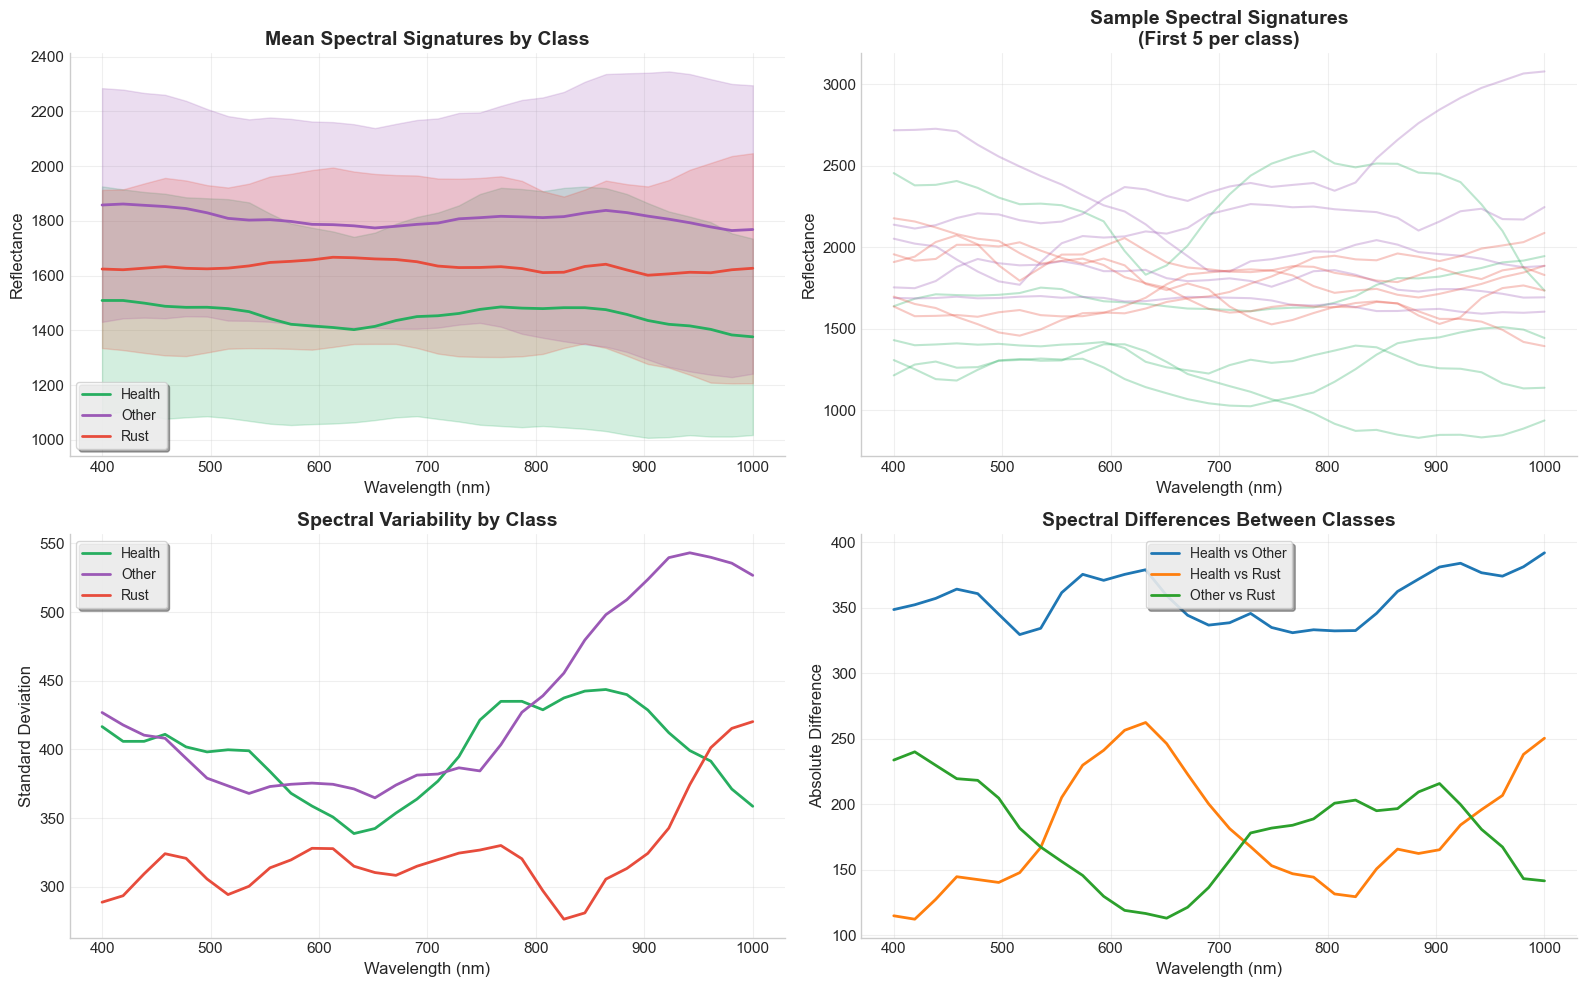

Figure saved: hs_spectral_signatures.png

KEY DISCRIMINATIVE WAVELENGTHS

Health vs Other:
  1000.0nm: difference = 392.09
  922.6nm: difference = 384.11
  980.6nm: difference = 381.41
  903.2nm: difference = 381.23
  632.3nm: difference = 379.15

Health vs Rust:
  632.3nm: difference = 262.49
  612.9nm: difference = 256.57
  1000.0nm: difference = 250.50
  651.6nm: difference = 246.37
  593.5nm: difference = 241.29

Other vs Rust:
  419.4nm: difference = 240.10
  400.0nm: difference = 233.82
  438.7nm: difference = 229.80
  458.1nm: difference = 219.61
  477.4nm: difference = 218.33


In [18]:
# ============================================================================
# SECTION 6: SPECTRAL SIGNATURE ANALYSIS
# ============================================================================

def extract_spectral_signatures(df, num_samples=20):
    """
    Extract mean spectral signatures for each class.
    """
    samples_per_class = {}
    
    print(f"Extracting spectral signatures from {num_samples} samples per class...")
    
    for cls in df['Class'].unique():
        class_df = df[df['Class'] == cls]
        sample_df = class_df.sample(min(num_samples, len(class_df)), random_state=42)
        
        class_signatures = []
        
        for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), 
                          desc=f"Processing {cls}", ncols=80, leave=False):
            try:
                img = tiff.imread(row['Path'])
                
                if img.ndim == 3 and img.shape[0] > img.shape[2]:
                    img = np.transpose(img, (2, 0, 1))
                
                # Calculate mean spectrum
                mean_spectrum = img.mean(axis=(1, 2))
                class_signatures.append(mean_spectrum)
                
            except Exception as e:
                continue
        
        if class_signatures:
            samples_per_class[cls] = np.array(class_signatures)
    
    return samples_per_class

# Extract signatures
signatures = extract_spectral_signatures(df_hs, num_samples=20)

# Determine number of bands from first sample
n_bands = list(signatures.values())[0].shape[1] if signatures else 0
print(f"\nNumber of spectral bands detected: {n_bands}")

# Generate wavelengths (assuming 400-1000nm range)
wavelengths = np.linspace(400, 1000, n_bands)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Mean spectral signatures
ax1 = axes[0, 0]
for cls, sigs in signatures.items():
    mean_sig = sigs.mean(axis=0)
    std_sig = sigs.std(axis=0)
    ax1.plot(wavelengths, mean_sig, label=cls, color=COLORS[cls], linewidth=2)
    ax1.fill_between(wavelengths, mean_sig - std_sig, mean_sig + std_sig, 
                     alpha=0.2, color=COLORS[cls])

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Reflectance')
ax1.set_title('Mean Spectral Signatures by Class', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Individual samples
ax2 = axes[0, 1]
for cls, sigs in signatures.items():
    for sig in sigs[:5]:  # Plot first 5 samples
        ax2.plot(wavelengths, sig, alpha=0.3, color=COLORS[cls])

ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflectance')
ax2.set_title('Sample Spectral Signatures\n(First 5 per class)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Spectral variability
ax3 = axes[1, 0]
for cls, sigs in signatures.items():
    std_sig = sigs.std(axis=0)
    ax3.plot(wavelengths, std_sig, label=cls, color=COLORS[cls], linewidth=2)

ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Standard Deviation')
ax3.set_title('Spectral Variability by Class', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Difference between classes
ax4 = axes[1, 1]
class_list = list(signatures.keys())
if len(class_list) >= 2:
    for i in range(len(class_list)):
        for j in range(i+1, len(class_list)):
            cls1, cls2 = class_list[i], class_list[j]
            mean1 = signatures[cls1].mean(axis=0)
            mean2 = signatures[cls2].mean(axis=0)
            diff = np.abs(mean1 - mean2)
            ax4.plot(wavelengths, diff, label=f'{cls1} vs {cls2}', linewidth=2)

ax4.set_xlabel('Wavelength (nm)')
ax4.set_ylabel('Absolute Difference')
ax4.set_title('Spectral Differences Between Classes', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hs_spectral_signatures.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: hs_spectral_signatures.png")

# Print key wavelengths with maximum differences
print("\n" + "=" * 60)
print("KEY DISCRIMINATIVE WAVELENGTHS")
print("=" * 60)
class_list = list(signatures.keys())
if len(class_list) >= 2:
    for i in range(len(class_list)):
        for j in range(i+1, len(class_list)):
            cls1, cls2 = class_list[i], class_list[j]
            mean1 = signatures[cls1].mean(axis=0)
            mean2 = signatures[cls2].mean(axis=0)
            diff = np.abs(mean1 - mean2)
            
            # Find top 5 wavelengths with maximum difference
            top_indices = np.argsort(diff)[-5:][::-1]
            top_wavelengths = wavelengths[top_indices]
            top_diffs = diff[top_indices]
            
            print(f"\n{cls1} vs {cls2}:")
            for wl, d in zip(top_wavelengths, top_diffs):
                print(f"  {wl:.1f}nm: difference = {d:.2f}")

---
## Section 7: Band Correlation Analysis (Clean Images Only)

> Analyze correlation between spectral bands.
> **Note: Analysis performed on filtered dataset excluding flagged images**

Calculating band correlations from 15 images...


Processing: 100%|██████████████████████████████| 15/15 [00:00<00:00, 680.03it/s]


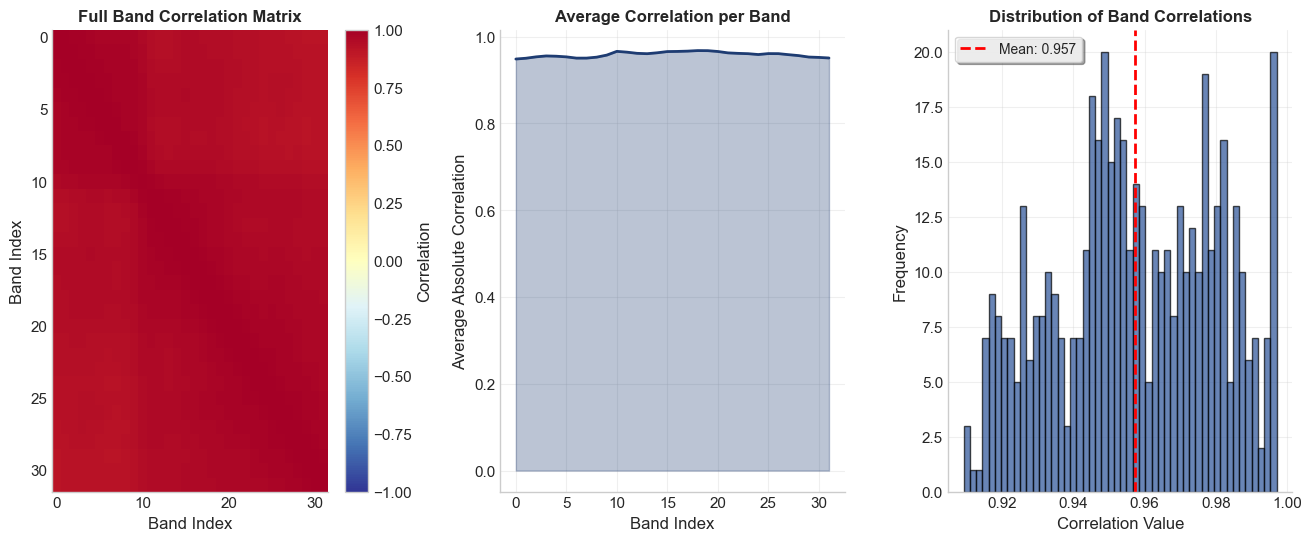

Figure saved: hs_correlation_analysis.png

CORRELATION STATISTICS
Mean correlation: 0.957
Median correlation: 0.956
Std correlation: 0.023
Min correlation: 0.909
Max correlation: 0.997

Highly correlated band pairs (r > 0.95): 302
First 10 pairs:
  Band 0 <-> Band 1: r = 0.997
  Band 0 <-> Band 2: r = 0.991
  Band 0 <-> Band 3: r = 0.987
  Band 0 <-> Band 4: r = 0.982
  Band 0 <-> Band 5: r = 0.976
  Band 0 <-> Band 6: r = 0.971
  Band 0 <-> Band 7: r = 0.972
  Band 0 <-> Band 8: r = 0.974
  Band 0 <-> Band 9: r = 0.970
  Band 0 <-> Band 10: r = 0.959


In [19]:
# ============================================================================
# SECTION 7: SPECTRAL BAND CORRELATION ANALYSIS
# ============================================================================

def calculate_band_correlation_hs(df, num_samples=15):
    """
    Calculate correlation matrix between spectral bands.
    """
    samples = df.sample(min(len(df), num_samples), random_state=42)
    
    all_spectra = []
    
    print(f"Calculating band correlations from {len(samples)} images...")
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Processing", ncols=80):
        try:
            img = tiff.imread(row['Path'])
            
            if img.ndim == 3 and img.shape[0] > img.shape[2]:
                img = np.transpose(img, (2, 0, 1))
            
            # Flatten spatial dimensions
            img_flat = img.reshape(img.shape[0], -1)
            
            # Sample pixels
            n_pixels = min(500, img_flat.shape[1])
            sampled_indices = np.random.choice(img_flat.shape[1], n_pixels, replace=False)
            all_spectra.append(img_flat[:, sampled_indices].T)
            
        except Exception as e:
            continue
    
    # Combine all spectra
    all_spectra = np.vstack(all_spectra)
    
    # Calculate correlation
    corr_matrix = np.corrcoef(all_spectra.T)
    
    return corr_matrix, all_spectra

corr_matrix, spectra_data = calculate_band_correlation_hs(df_hs)

# Visualization
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, wspace=0.3)

# --- Chart 1: Full Correlation Heatmap ---
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Full Band Correlation Matrix', fontweight='bold', fontsize=12)
ax1.set_xlabel('Band Index')
ax1.set_ylabel('Band Index')
plt.colorbar(im1, ax=ax1, label='Correlation')

# Add grid
ax1.grid(False)

# --- Chart 2: Average Correlation per Band ---
ax2 = fig.add_subplot(gs[1])
avg_corr = np.mean(np.abs(corr_matrix), axis=0)
ax2.plot(range(len(avg_corr)), avg_corr, color=COLORS['primary'], linewidth=2)
ax2.fill_between(range(len(avg_corr)), avg_corr, alpha=0.3, color=COLORS['primary'])
ax2.set_xlabel('Band Index')
ax2.set_ylabel('Average Absolute Correlation')
ax2.set_title('Average Correlation per Band', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# --- Chart 3: Correlation Distribution ---
ax3 = fig.add_subplot(gs[2])
# Remove diagonal (self-correlation)
corr_values = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
ax3.hist(corr_values, bins=50, color=COLORS['secondary'], alpha=0.7, edgecolor='black')
ax3.axvline(corr_values.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {corr_values.mean():.3f}')
ax3.set_xlabel('Correlation Value')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Band Correlations', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hs_correlation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: hs_correlation_analysis.png")

# Print statistics
print("\n" + "=" * 60)
print("CORRELATION STATISTICS")
print("=" * 60)
print(f"Mean correlation: {corr_values.mean():.3f}")
print(f"Median correlation: {np.median(corr_values):.3f}")
print(f"Std correlation: {corr_values.std():.3f}")
print(f"Min correlation: {corr_values.min():.3f}")
print(f"Max correlation: {corr_values.max():.3f}")

# Find highly correlated bands (>0.95)
high_corr = np.where(np.triu(corr_matrix, k=1) > 0.95)
if len(high_corr[0]) > 0:
    print(f"\nHighly correlated band pairs (r > 0.95): {len(high_corr[0])}")
    print("First 10 pairs:")
    for i in range(min(10, len(high_corr[0]))):
        b1, b2 = high_corr[0][i], high_corr[1][i]
        print(f"  Band {b1} <-> Band {b2}: r = {corr_matrix[b1, b2]:.3f}")

---
## Section 8: Sample Image Visualization (Clean Images Only)

> Display sample HS images with selected spectral bands.
> **Note: Analysis performed on filtered dataset excluding flagged images**

Displaying 3 HS images with selected bands:

Image 1: Health_hyper_62.tif (Class: Health)
   Shape: (32, 32, 125) (Channels=32, Height=32, Width=125)
   Dtype: uint16, Range: [13, 3935]


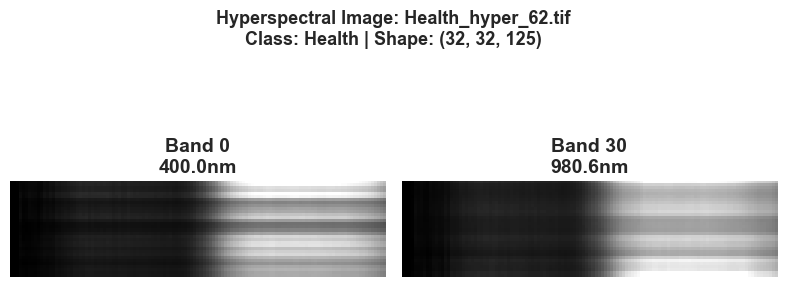


Image 2: Other_hyper_30.tif (Class: Other)
   Shape: (32, 32, 125) (Channels=32, Height=32, Width=125)
   Dtype: uint16, Range: [490, 3646]


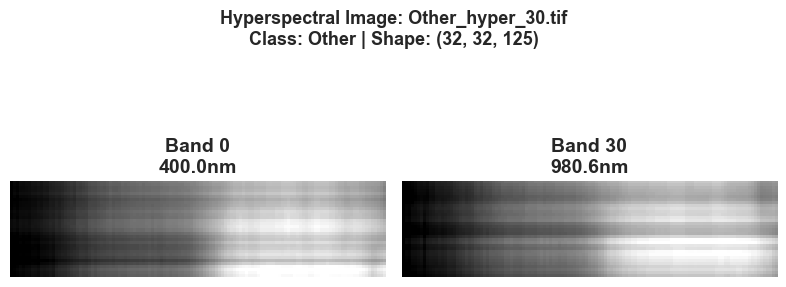


Image 3: Rust_hyper_185.tif (Class: Rust)
   Shape: (32, 32, 126) (Channels=32, Height=32, Width=126)
   Dtype: uint16, Range: [12, 65535]


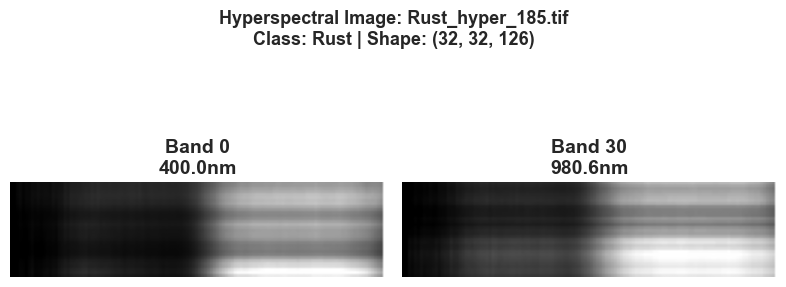


Visualization completed!


In [20]:
# ============================================================================
# SECTION 8: SAMPLE IMAGE VISUALIZATION
# ============================================================================

def visualize_hs_samples(df, n_samples=3, bands_to_show=[0, 30, 60, 90, 120]):
    """
    Visualize sample HS images with selected bands.
    
    Parameters:
    -----------
    df : pd.DataFrame
    n_samples : int - Number of samples to show
    bands_to_show : list - Indices of bands to display
    """
    
    samples = []
    for cls in df['Class'].unique():
        class_df = df[df['Class'] == cls]
        sample = class_df.sample(min(1, len(class_df)), random_state=42)
        samples.append(sample)
    
    samples_df = pd.concat(samples).head(n_samples)
    
    print(f"Displaying {len(samples_df)} HS images with selected bands:")
    print("=" * 80)
    
    for idx, (_, row) in enumerate(samples_df.iterrows()):
        print(f"\nImage {idx+1}: {row['File Name']} (Class: {row['Class']})")
        
        try:
            img = tiff.imread(row['Path'])
            
            if img.ndim == 3 and img.shape[0] > img.shape[2]:
                img = np.transpose(img, (2, 0, 1))
            
            c, h, w = img.shape
            print(f"   Shape: {img.shape} (Channels={c}, Height={h}, Width={w})")
            print(f"   Dtype: {img.dtype}, Range: [{img.min()}, {img.max()}]")
            
            # Adjust bands to show based on actual number of channels
            actual_bands = [b for b in bands_to_show if b < c]
            n_bands = len(actual_bands)
            
            # Create wavelengths
            wls = np.linspace(400, 1000, c)
            
            fig, axes = plt.subplots(1, n_bands, figsize=(4*n_bands, 4))
            if n_bands == 1:
                axes = [axes]
            
            for i, band_idx in enumerate(actual_bands):
                band_data = img[band_idx].astype(np.float32)
                
                # Normalize
                vmin, vmax = np.percentile(band_data, [2, 98])
                band_normalized = np.clip((band_data - vmin) / (vmax - vmin + 1e-8), 0, 1)
                
                axes[i].imshow(band_normalized, cmap='gray')
                axes[i].set_title(f'Band {band_idx}\n{wls[band_idx]:.1f}nm', fontweight='bold')
                axes[i].axis('off')
            
            plt.suptitle(f'Hyperspectral Image: {row["File Name"]}\n'
                        f'Class: {row["Class"]} | Shape: {img.shape}',
                        fontsize=13, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'hs_sample_{idx+1}.png', dpi=150, bbox_inches='tight', facecolor='white')
            plt.show()
            
        except Exception as e:
            print(f"   Error: {e}")
            continue
    
    print("\n" + "=" * 80)
    print("Visualization completed!")

# Visualize samples
visualize_hs_samples(df_hs, n_samples=3, bands_to_show=[0, 30, 60, 90, 120, 149])

---
## Section 9: Dimensionality Analysis (Clean Images Only)

> Analyze the high dimensionality of hyperspectral data.
> **Note: Analysis performed on filtered dataset excluding flagged images**

DIMENSIONALITY ANALYSIS

Band count statistics:
count    577.0
mean      32.0
std        0.0
min       32.0
25%       32.0
50%       32.0
75%       32.0
max       32.0
Name: Channels, dtype: float64

Total pixels across all images: 2,311,456
Total bands across all images: 18,464
Total data points: 73,966,592
Average data points per image: 128,192


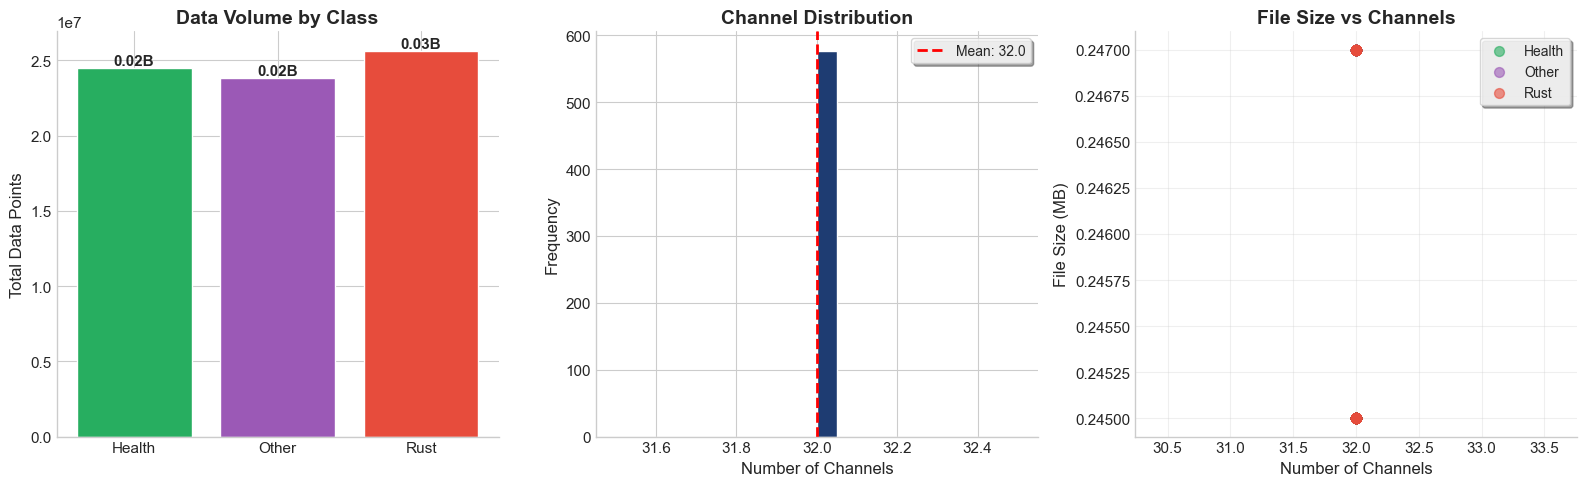


Figure saved: hs_dimensionality_analysis.png


In [21]:
# ============================================================================
# SECTION 9: DIMENSIONALITY ANALYSIS
# ============================================================================

# Get band count distribution
print("=" * 60)
print("DIMENSIONALITY ANALYSIS")
print("=" * 60)

print("\nBand count statistics:")
print(df_hs['Channels'].describe())

# Calculate data volume
total_pixels = df_hs['Total Pixels'].sum()
total_bands = df_hs['Channels'].sum()
total_data_points = df_hs.apply(lambda x: x['Total Pixels'] * x['Channels'], axis=1).sum()

print(f"\nTotal pixels across all images: {total_pixels:,}")
print(f"Total bands across all images: {total_bands:,}")
print(f"Total data points: {total_data_points:,}")
print(f"Average data points per image: {total_data_points/len(df_hs):,.0f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Data volume by class
ax1 = axes[0]
data_volume = df_hs.groupby('Class').apply(
    lambda x: (x['Total Pixels'] * x['Channels']).sum()
)
colors = [COLORS[cls] for cls in data_volume.index]
bars = ax1.bar(range(len(data_volume)), data_volume.values, color=colors, edgecolor='white')
ax1.set_xticks(range(len(data_volume)))
ax1.set_xticklabels(data_volume.index)
ax1.set_ylabel('Total Data Points')
ax1.set_title('Data Volume by Class', fontweight='bold')

for bar, val in zip(bars, data_volume.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val/1e9:.2f}B', ha='center', va='bottom', fontweight='bold')

# Plot 2: Channels distribution
ax2 = axes[1]
df_hs['Channels'].hist(bins=20, ax=ax2, color=COLORS['primary'], edgecolor='white')
ax2.axvline(df_hs['Channels'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Mean: {df_hs['Channels'].mean():.1f}")
ax2.set_xlabel('Number of Channels')
ax2.set_ylabel('Frequency')
ax2.set_title('Channel Distribution', fontweight='bold')
ax2.legend()

# Plot 3: File size vs channels
ax3 = axes[2]
for cls in df_hs['Class'].unique():
    subset = df_hs[df_hs['Class'] == cls]
    ax3.scatter(subset['Channels'], subset['File Size (MB)'], 
               label=cls, color=COLORS[cls], alpha=0.6, s=50)

ax3.set_xlabel('Number of Channels')
ax3.set_ylabel('File Size (MB)')
ax3.set_title('File Size vs Channels', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hs_dimensionality_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved: hs_dimensionality_analysis.png")

---
## Section 10: Summary & Recommendations (Clean Images Only)

> Final summary and recommendations for hyperspectral data processing.
> **Note: Summary based on filtered dataset excluding flagged images**

In [ ]:
# ============================================================================
# SECTION 10: SUMMARY & RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("HYPERSPECTRAL DATA ANALYSIS SUMMARY")
print("=" * 80)

# Dataset Overview
print("\n1. DATASET OVERVIEW (CLEAN IMAGES)")
print("-" * 80)
print(f"   Total clean images: {len(df_hs)}")
print(f"   Original total: {len(df_hs_original)}")
print(f"   Removed (flagged): {len(df_hs_original) - len(df_hs)}")
print(f"   Retention rate: {len(df_hs)/len(df_hs_original)*100:.1f}%")
print(f"   Number of classes: {df_hs['Class'].nunique()}")
print(f"   Class distribution: {dict(df_hs['Class'].value_counts())}")
print(f"   Average spectral bands: {df_hs['Channels'].mean():.1f}")
print(f"   Typical image size: {df_hs['Resolution'].mode().iloc[0] if not df_hs.empty else 'N/A'}")

# Data Quality
print("\n2. DATA QUALITY")
print("-" * 80)
quality_summary = df_quality['status'].value_counts()
print(f"   OK images: {quality_summary.get('ok', 0)}")
print(f"   Flagged images: {quality_summary.get('flagged', 0)}")
print(f"   Corrupt images: {quality_summary.get('corrupt', 0)}")
if len(df_flagged) > 0:
    print(f"   Most common issues: {df_flagged['reason'].value_counts().head(3).to_dict()}")

# Spectral Characteristics
print("\n3. SPECTRAL CHARACTERISTICS")
print("-" * 80)
print(f"   Number of spectral bands: {n_bands}")
print(f"   Wavelength range: {HS_WAVELENGTH_RANGE[0]}-{HS_WAVELENGTH_RANGE[1]}nm")
print(f"   Spectral resolution: ~{(HS_WAVELENGTH_RANGE[1]-HS_WAVELENGTH_RANGE[0])/n_bands:.2f}nm/band")

# Dimensionality
print("\n4. DIMENSIONALITY")
print("-" * 80)
print(f"   Average data points per image: {total_data_points/len(df_hs):,.0f}")
print(f"   Total dataset data points: {total_data_points:,.0f}")
print(f"   Average file size: {df_hs['File Size (MB)'].mean():.2f} MB")
print(f"   Total dataset size: {df_hs['File Size (MB)'].sum():.2f} MB")

# Recommendations
print("\n5. RECOMMENDATIONS")
print("-" * 80)
recommendations = [
    "Dimensionality Reduction: Consider PCA, MNF, or band selection to reduce computational cost",
    "Preprocessing: Apply spectral smoothing (Savitzky-Golay filter) to reduce noise",
    "Feature Extraction: Extract vegetation indices, spectral derivatives, or absorption features",
    "Classification: Use specialized HS classifiers (SVM, Random Forest, or CNN-based methods)",
    "Data Augmentation: Use spectral mixing, spatial augmentation for better generalization",
    "Band Selection: Identify and use most discriminative bands based on correlation analysis",
    "Normalization: Apply standard normal variate (SNV) or min-max normalization",
    "Quality Control: Remove flagged images or apply correction algorithms"
]

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

# Key findings
print("\n6. KEY FINDINGS")
print("-" * 80)
if signatures:
    print(f"   Spectral signatures show clear discrimination between classes")
    print(f"   High band correlation suggests redundancy - dimensionality reduction recommended")
    print(f"   Class balance: {dict(df_hs['Class'].value_counts())}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)

# Save summary report
summary_report = {
    'Total Clean Images': len(df_hs),
    'Original Total Images': len(df_hs_original),
    'Removed (Flagged)': len(df_hs_original) - len(df_hs),
    'Retention Rate (%)': round(len(df_hs)/len(df_hs_original)*100, 2),
    'Number of Classes': df_hs['Class'].nunique(),
    'Average Spectral Bands': df_hs['Channels'].mean(),
    'Total Dataset Size (MB)': df_hs['File Size (MB)'].sum(),
    'OK Images': quality_summary.get('ok', 0),
    'Flagged Images': quality_summary.get('flagged', 0),
    'Corrupt Images': quality_summary.get('corrupt', 0)
}

pd.DataFrame([summary_report]).to_csv('hs_analysis_summary.csv', index=False)
print("\nSummary report saved: hs_analysis_summary.csv")


HYPERSPECTRAL DATA ANALYSIS SUMMARY

1. DATASET OVERVIEW (CLEAN IMAGES)
--------------------------------------------------------------------------------
   Total clean images: 577
   Original total: 600
   Removed (flagged): 23
   Retention rate: 96.2%
   Number of classes: 3
   Class distribution: {'Rust': 200, 'Health': 191, 'Other': 186}
   Average spectral bands: 32.0
   Typical image size: 32x125

2. DATA QUALITY
--------------------------------------------------------------------------------
   OK images: 577
   Flagged images: 23
   Corrupt images: 0
   Most common issues: {'near_black,low_contrast': 23}

3. SPECTRAL CHARACTERISTICS
--------------------------------------------------------------------------------
   Number of spectral bands: 32
   Wavelength range: 400-1000nm
   Spectral resolution: ~18.75nm/band

4. DIMENSIONALITY
--------------------------------------------------------------------------------
   Average data points per image: 128,192
   Total dataset data poin

: 